In [17]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [18]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [19]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [20]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [21]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [22]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [23]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date

'2017-08-23'

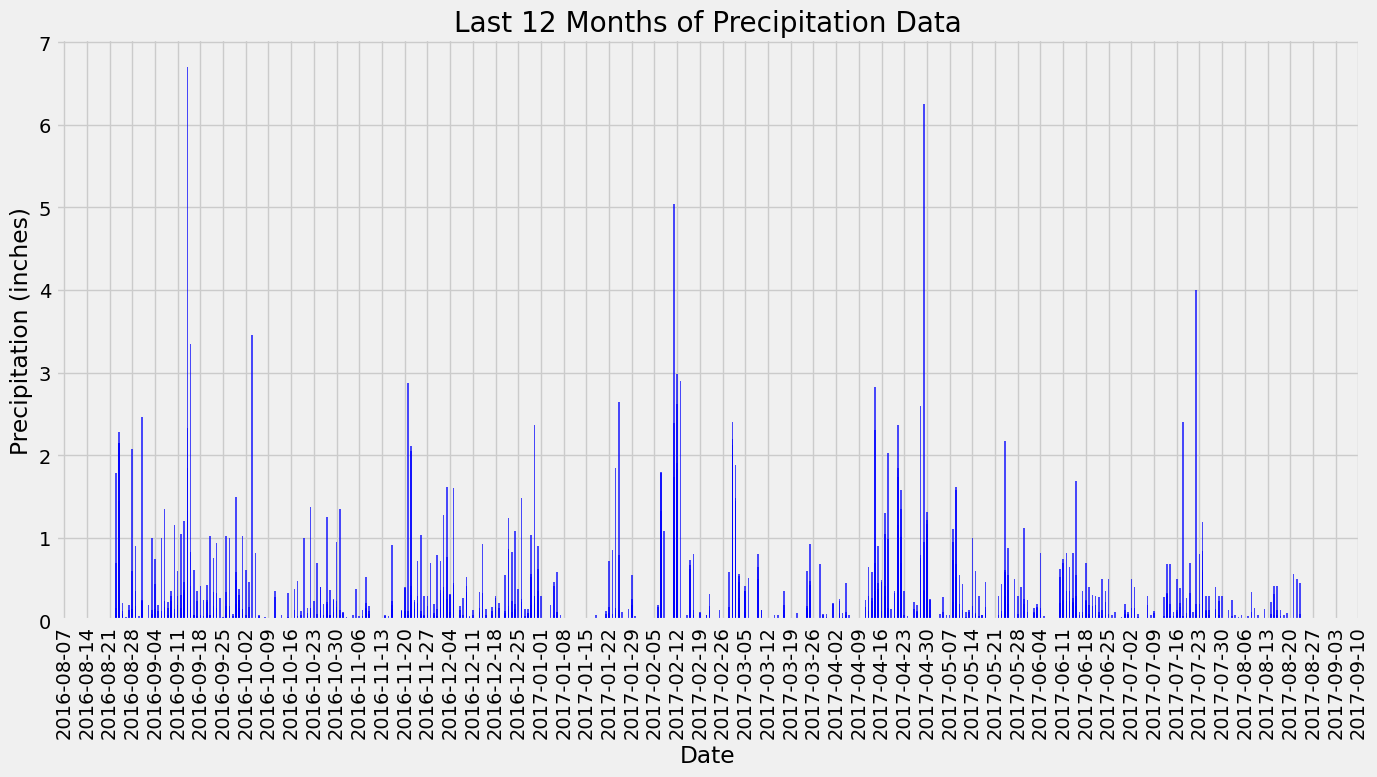

In [26]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database.
# Calculate the date one year from the last date in data set.
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the date and precipitation scores
last_12_months_data = session.query(Measurement.date, Measurement.prcp) \
    .filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prev_year_df = pd.DataFrame(last_12_months_data, columns=["Date", "Precipitation"])

# Sort the dataframe by date
prev_year_df["Date"] = pd.to_datetime(prev_year_df["Date"])
prev_year_sorted = prev_year_df.sort_values("Date")

# Convert the 'Date' column to datetime format
prev_year_sorted['Date'] = pd.to_datetime(prev_year_sorted['Date'])

# Use Pandas Plotting with Matplotlib to plot the data
import matplotlib.dates as mdates

plt.figure(figsize=(14, 8))  
plt.bar(prev_year_sorted['Date'], prev_year_sorted['Precipitation'], width=0.5, color='b', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Last 12 Months of Precipitation Data')
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  
plt.tight_layout()
plt.show()


In [27]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = prev_year_sorted['Precipitation'].describe()
print(summary_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [33]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
total_stations

9

In [35]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Station.station, func.count(Measurement.station)).\
    filter(Station.station == Measurement.station).\
    group_by(Station.station).\
    order_by(func.count(Measurement.station).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

#Extract the results
for result in temp_stats:
    min_temp, max_temp, avg_temp = result

print(f"Lowest Temperature: {min_temp}")
print(f"Highest Temperature: {max_temp}")
print(f"Average Temperature: {avg_temp}")

Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


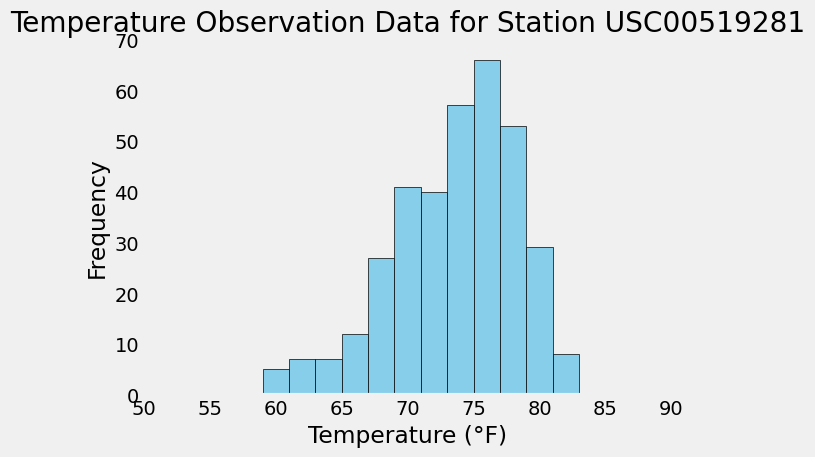

In [41]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_twelve_months_station_data = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= '2016-08-23').all()

# Extract the temperature data
temps = [temp[0] for temp in last_twelve_months_station_data]

# Plotting the histogram
plt.hist(temps, bins=12, color='skyblue', edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observation Data for Station USC00519281')
plt.grid(False)
plt.ylim(0,70)
plt.xlim(50,90)
plt.tight_layout()
plt.show()

# Close Session

In [42]:
# Close Session
session.close()